In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
import sys
import os
from scipy import interpolate
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from scipy.optimize import curve_fit
import astropy.units as u
import astropy.constants as c
from astropy.timeseries import LombScargle

In [3]:
import matplotlib.font_manager as font_manager
%matplotlib inline
font_prop = font_manager.FontProperties(size=16)

In [4]:
import stingray as sr
from stingray.events import EventList
from stingray.lightcurve import Lightcurve

In [5]:
from stingray import Lightcurve, Crossspectrum, sampledata,Powerspectrum,AveragedPowerspectrum
from stingray.simulator import simulator, models

In [50]:
sim = simulator.Simulator(N=1024, mean=550, dt=100.,)

In [60]:
lc=sim.simulate(1)

In [58]:
# lc.counts+=sim.mean

1024


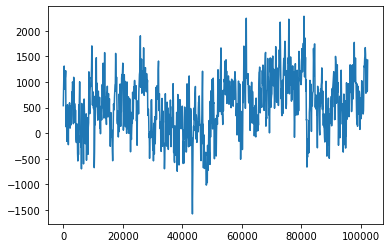

In [61]:
plt.plot(lc.time,lc.counts)
print(len(lc.counts))

In [14]:
w=np.arange(1/10000.,1/100.,1./10000)

In [16]:
spectrum=np.power(w,-2)

In [37]:
def bending_po(x,p):
    """
    Parameters
    ----------
    :param x:numpy.ndarray
        non-zero frequencies
    :param p:
    p[0] = bending frequency
    p[1] = alpha,即 power law index、
    p[2] = constant
    p[3] = normalization N
    :return:
    """
    return p[3]*x**(-1)*(1+(x/p[0])**(p[1]-1))**(-1)+p[2]

def generalized_lorentzian(x, p):
    """
    Generalized Lorentzian function.

    Parameters
    ----------

    x: numpy.ndarray
        non-zero frequencies

    p: iterable
        p[0] = peak centeral frequency
        p[1] = FWHM of the peak (gamma)
        p[2] = peak value at x=x0
        p[3] = power coefficient [n]

    Returns
    -------
    model: numpy.ndarray
        generalized lorentzian psd model
    """

    assert p[3] > 0., "The power coefficient should be greater than zero."
    return p[2] * (p[1] / 2)**p[3] * 1./(abs(x - p[0])**p[3] + (p[1] / 2)**p[3])


def smoothbknpo(x, p):
    """
    Smooth broken power law function.

    Parameters
    ----------

    x: numpy.ndarray
        non-zero frequencies

    p: iterable
        p[0] = normalization frequency
        p[1] = power law index for f --> zero
        p[2] = power law index for f --> infinity
        p[3] = break frequency

    Returns
    -------
    model: numpy.ndarray
        generalized smooth broken power law psd model
    """

    return p[0] * x**(-p[1]) / (1. + (x / p[3])**2)**(-(p[1] - p[2]) / 2)

In [28]:
ps = Powerspectrum(lc)
print("\nSize of positive Fourier frequencies:", len(ps.freq))
print("Number of data points per segment:", ps.n)


Size of positive Fourier frequencies: 511
Number of data points per segment: 1024


200it [00:00, 1051.32it/s]


Number of segments: 200


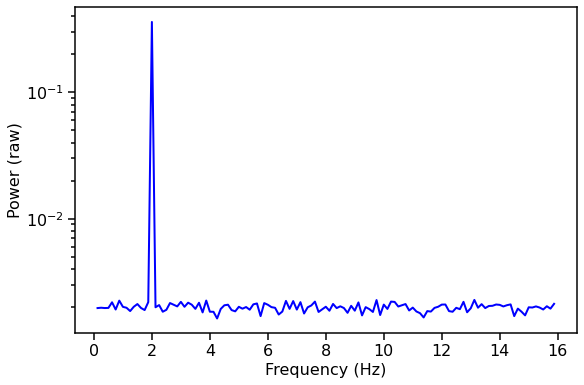

In [29]:
avg_ps = AveragedPowerspectrum(long_lc, 8.)
print("Number of segments: %d" % avg_ps.m)
fig, ax1 = plt.subplots(1,1,figsize=(9,6))
ax1.plot(avg_ps.freq, avg_ps.power, lw=2, color='blue')
ax1.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax1.set_ylabel("Power (raw)", fontproperties=font_prop)
ax1.set_yscale('log')
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.tick_params(which='major', width=1.5, length=7)
ax1.tick_params(which='minor', width=1.5, length=4)
for axis in ['top', 'bottom', 'left', 'right']:
    ax1.spines[axis].set_linewidth(1.5)
plt.show()

In [30]:
dt=100.
cts_rate=1e-3
sim = simulator.Simulator(N=1024, mean=cts_rate, dt=dt)
w = np.fft.rfftfreq(sim.N, d=sim.dt)[1:]
spectrum=smoothbknpo(w,[1.5,0.2,0.4,1e-4])+generalized_lorentzian(w,[1/500.,1/3000.,5,1.4])
lc = sim.simulate(spectrum)
times = lc.time
counts = lc.counts
n_bin = len(counts)
bin_start = 0
maxlc = np.max(counts)
intlc = maxlc * n_bin
n_events_predict = int(intlc + 10 * np.sqrt(intlc))
events_per_bin_predict = n_events_predict / n_bin

In [31]:
print(intlc)
print(events_per_bin_predict)

4.169099537452389
0.0234375


In [36]:
from stingray.events import EventList

In [37]:
sim = simulator.Simulator(N=1024, mean=0.5, dt=0.125)
sample = sampledata.sample_data().counts
lc = sim.simulate(1)
print(np.sort(lc.counts))

[-0.9607396  -0.75606935 -0.75086615 ...  1.95860974  1.99511107
  2.18274853]


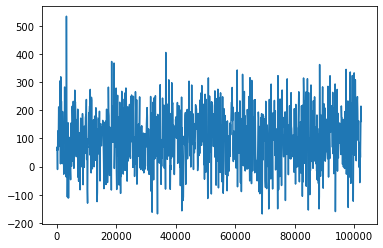

In [39]:
dt=100
cts_rate=100
num_bins=1024
sim = simulator.Simulator(N=num_bins, mean=cts_rate, dt=dt)
w = np.fft.rfftfreq(sim.N, d=sim.dt)[1:]
lc = sim.simulate('generalized_lorentzian', [1.5, .2, 1.2, 1.4])
plt.plot(lc.time,lc.counts)

In [40]:
simulate_model(spectrum)

NameError: name 'simulate_model' is not defined

In [41]:
# Array of timestamps, 10000 bins from 1s to 100s
times = np.linspace(1,100,10000)

# base component of the lightcurve, poisson-like
# the averaged count-rate is 100 counts/bin
noise = np.random.poisson(100,10000)

# time evolution of the frequency of our fake periodic signal
# the frequency changes with a sinusoidal shape around the value 24Hz
# freq = 25 + 1.2*np.sin(2*np.pi*times/130)

# # Our fake periodic variability with drifting frequency
# # the amplitude of this variability is 10% of the base flux
# var = 10*np.sin(2*np.pi*freq*times)

# The signal of our lightcurve is equal the base flux plus the variable flux
signal = noise
lc = sr.Lightcurve(times, signal)

In [42]:
ps = sr.Powerspectrum(lc)

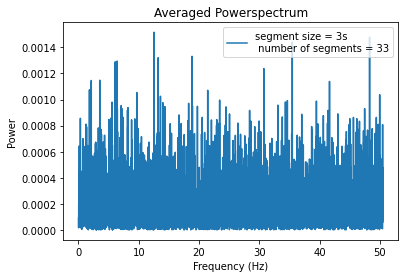

In [43]:
plt.plot(ps.freq, ps.power, label='segment size = {}s \n number of segments = {}'.format(3, int(lc.tseg/3)))
plt.title('Averaged Powerspectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend()

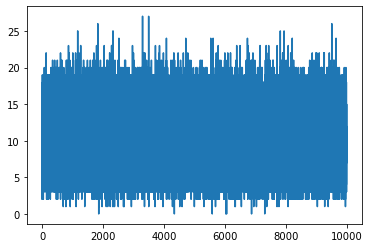

In [44]:
N=100000
mean=10
times = np.linspace(1,10000,N)
freq_p = 0.001
# Our fake periodic variability with drifting frequency
# the amplitude of this variability is 10% of the base flux
var = 0.001*mean**np.sin(2*np.pi*freq_p*times)

noise = np.random.poisson(mean,N)
lc=Lightcurve(times,noise+var,dt=1.)
plt.plot(lc.time,lc.counts)

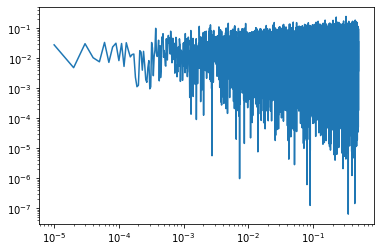

In [45]:
ps = Powerspectrum(lc)
plt.loglog()
plt.plot(ps.freq,ps.power)

In [46]:
def get_LS(time, flux,freq):
    x = time
    y = flux
    # dy=np.sqrt(y)
    # plt.scatter(x,y)
    # plt.show()

    # LS = LombScargle(x, y, dy = 1, normalization = 'standard', fit_mean = True,
    #                  center_data = True).power(freq, method = 'cython')
    LS = LombScargle(x, y,normalization = 'standard')
    # LS = LombScargle(x, y, dy, normalization='psd')
    power = LS.power(freq)

    # print('freq_num={0}'.format(len(freq)))
    FP=LS.false_alarm_probability(power.max(),minimum_frequency = freq[0], maximum_frequency = freq[-1],method='naive')
    FP_99 = LS.false_alarm_level(0.01, minimum_frequency = freq[0], maximum_frequency = freq[-1],method='naive')
    FP_90 = LS.false_alarm_level(0.1,  minimum_frequency=freq[0],
                                 maximum_frequency=freq[-1], method='naive')
    FP_68 = LS.false_alarm_level(0.32, minimum_frequency=freq[0],
                                 maximum_frequency=freq[-1], method='naive')

    # if FP<0.01:print(dataname)
    plt.title('FP={0}'.format(FP))
    plt.semilogx()
    plt.plot(freq, power)
    print(1./freq[np.where(power==np.max(power))])
    plt.plot([freq[0], freq[-1]], [FP_99, FP_99], '--')
    plt.plot([freq[0], freq[-1]], [FP_90, FP_90], '--')
    plt.plot([freq[0], freq[-1]], [FP_68, FP_68], '--')
    plt.show()

    return [FP, 1. / freq[np.where(power == np.max(power))]]


In [47]:
%matplotlib widget 
dt=1
lc_new=lc
T_exp=lc_new.time[-1]-lc_new.time[0]
freq=np.arange(1/T_exp,0.5/dt,1/T_exp)
# freq=freq[np.where(freq > 1 / 10000.)]
temp=get_LS(lc_new.time, lc_new.counts, freq=freq)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[2.03314355]
